# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

1. Clean the data and perform some EDA and visualization to get to know the data set.

In [45]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



In [33]:
df = pd.read_csv("data/cars_hw.csv")
df = pd.DataFrame(df)

In [34]:
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [35]:
df.shape

(976, 12)

In [36]:
# Column "Unnamed: 0" can be dropped
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [37]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
dtype: int64


In [38]:
# Basic info
print("\nData types:\n", df.dtypes)

# Summary stats for numeric columns
print("\nSummary statistics:\n", df.describe())


Data types:
 Make                 object
Make_Year             int64
Color                object
Body_Type            object
Mileage_Run           int64
No_of_Owners         object
Seating_Capacity      int64
Fuel_Type            object
Transmission         object
Transmission_Type    object
Price                 int64
dtype: object

Summary statistics:
          Make_Year   Mileage_Run  Seating_Capacity         Price
count   976.000000    976.000000        976.000000  9.760000e+02
mean   2016.963115  41571.195697          5.095287  7.410195e+05
std       2.818742  24390.995134          0.446224  3.673234e+05
min    2011.000000   1117.000000          4.000000  1.880000e+05
25%    2015.000000  22676.750000          5.000000  4.757500e+05
50%    2017.000000  37570.500000          5.000000  6.665000e+05
75%    2019.000000  57421.250000          5.000000  8.830000e+05
max    2022.000000  99495.000000          8.000000  2.941000e+06


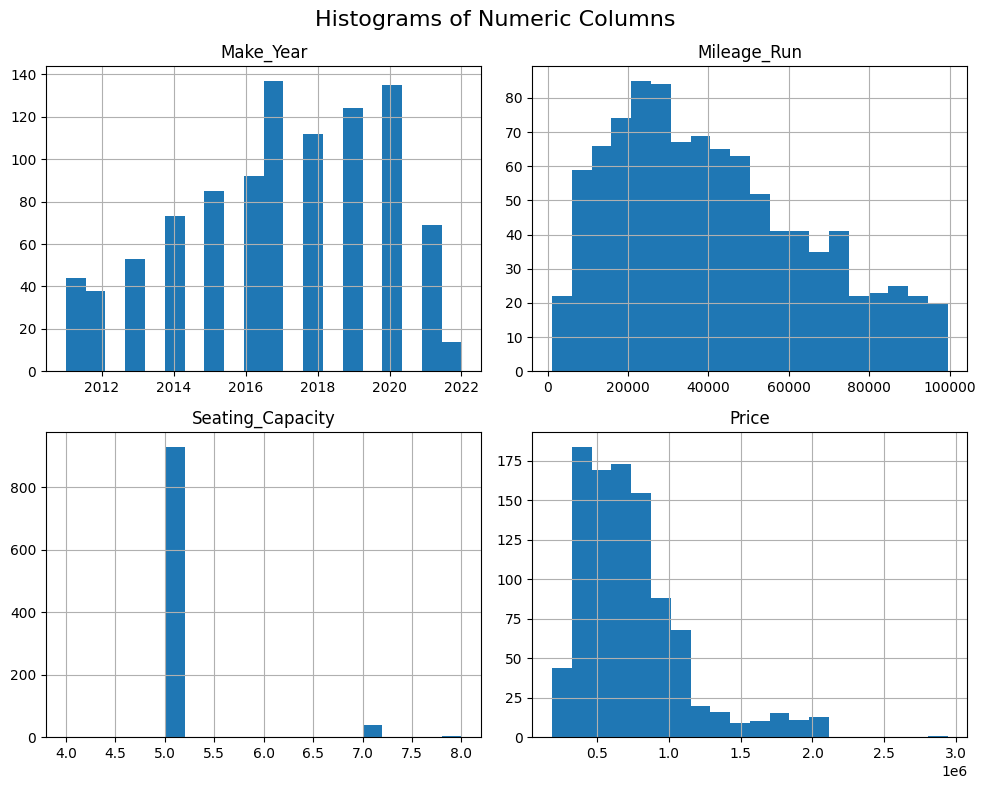

In [39]:
# Numeric column histograms
numeric_cols = ['Make_Year', 'Mileage_Run', 'Seating_Capacity', 'Price']
df[numeric_cols].hist(bins=20, figsize=(10, 8))
plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

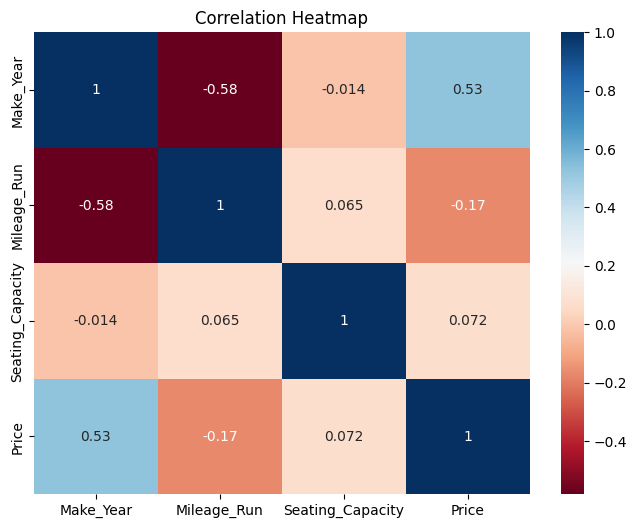

In [40]:
# Heatmap of corelation 
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="RdBu")
plt.title("Correlation Heatmap")
plt.show()

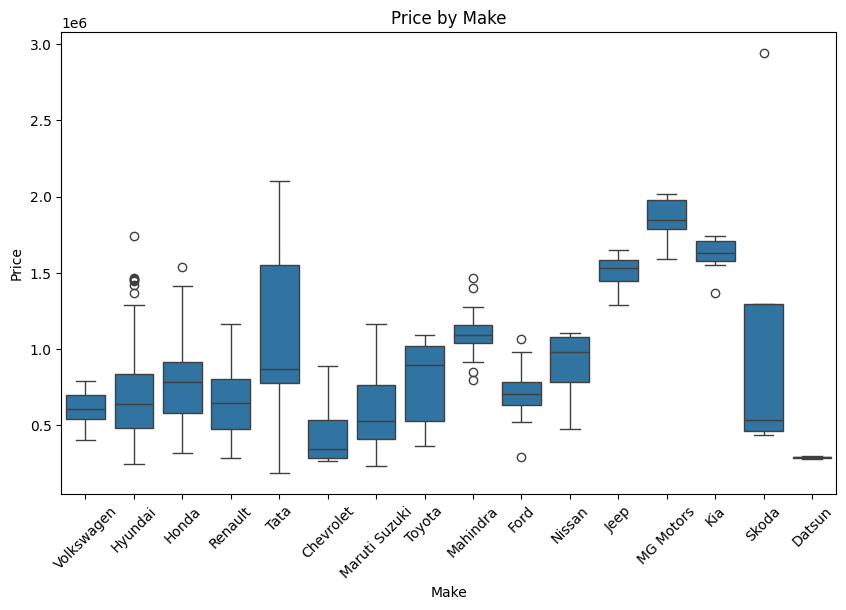

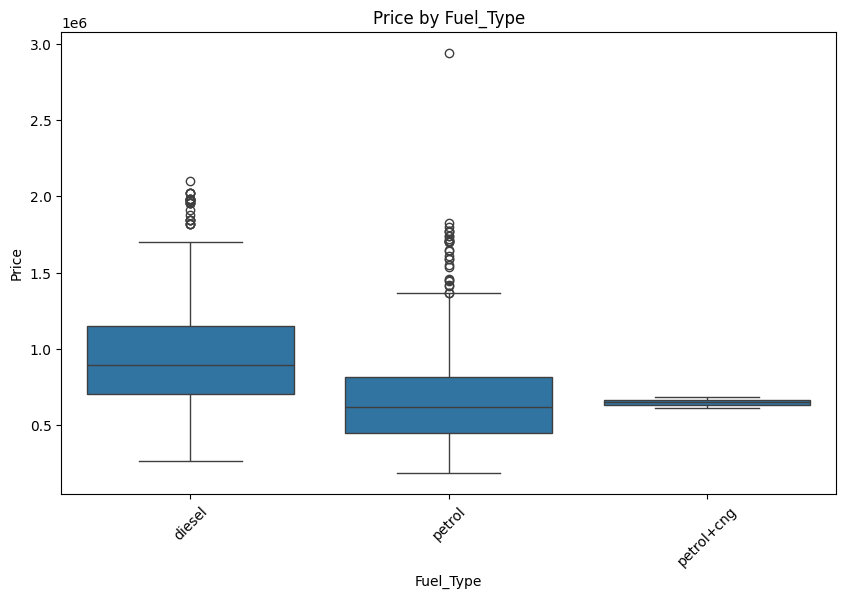

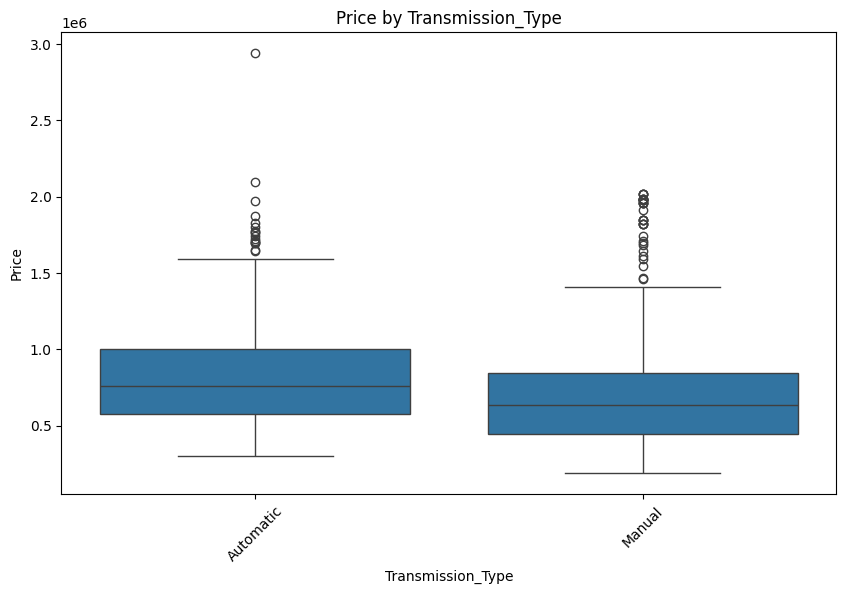

In [41]:
# Price by categorical variables boxplots
categorical_vars = ['Make', 'Fuel_Type', 'Transmission_Type']
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=var, y='Price', data=df)
    plt.xticks(rotation=45)
    plt.title(f'Price by {var}')
    plt.show()

2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [42]:
categorical_cols = ['Make', 'Color', 'Body_Type', 'No_of_Owners', 'Fuel_Type', 'Transmission', 'Transmission_Type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

3. Implement an ~80/~20 train-test split. Put the test data aside.

In [50]:
X = df_encoded.drop("Price", axis=1)
y = df_encoded["Price"]

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm the shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (780, 45), (780,)
Test set: (196, 45), (196,)


4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [54]:
# Numeric
X_a = df_encoded[['Make_Year', 'Mileage_Run', 'Seating_Capacity']]
X_train, X_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

model_a = LinearRegression()
model_a.fit(X_train, y_train)

train_pred_a = model_a.predict(X_train)
test_pred_a = model_a.predict(X_test)

print("Model A (Numeric Only)")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred_a)):.2f}, R^2: {r2_score(y_train, train_pred_a):.3f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, test_pred_a)):.2f}, R^2: {r2_score(y_test, test_pred_a):.3f}")

# Numeric and fuel type
fuel_cols = [col for col in df_encoded.columns if col.startswith('Fuel_Type_')]
X_b = df_encoded[['Make_Year', 'Mileage_Run', 'Seating_Capacity'] + fuel_cols]
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

model_b = LinearRegression()
model_b.fit(X_train, y_train)

train_pred_b = model_b.predict(X_train)
test_pred_b = model_b.predict(X_test)

print("Model B (Numeric + Fuel Type)")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred_b)):.2f}, R^2: {r2_score(y_train, train_pred_b):.3f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, test_pred_b)):.2f}, R^2: {r2_score(y_test, test_pred_b):.3f}")

# All features
X_c = df_encoded.drop(columns=["Price"])
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

model_c = LinearRegression()
model_c.fit(X_train, y_train)

train_pred_c = model_c.predict(X_train)
test_pred_c = model_c.predict(X_test)

print("Model C (All Features)")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred_c)):.2f}, R^2: {r2_score(y_train, train_pred_c):.3f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, test_pred_c)):.2f}, R^2: {r2_score(y_test, test_pred_c):.3f}")

Model A (Numeric Only)
Train RMSE: 309338.37, R^2: 0.314
Test  RMSE: 284546.95, R^2: 0.294
Model B (Numeric + Fuel Type)
Train RMSE: 279778.53, R^2: 0.439
Test  RMSE: 271671.79, R^2: 0.357
Model C (All Features)
Train RMSE: 142114.26, R^2: 0.855
Test  RMSE: 143575.20, R^2: 0.820


Model C, which includes all features has by far the lowest RMSE and the highest R^2.

5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 


ValueError: num must be an integer with 1 <= num <= 3, not 4

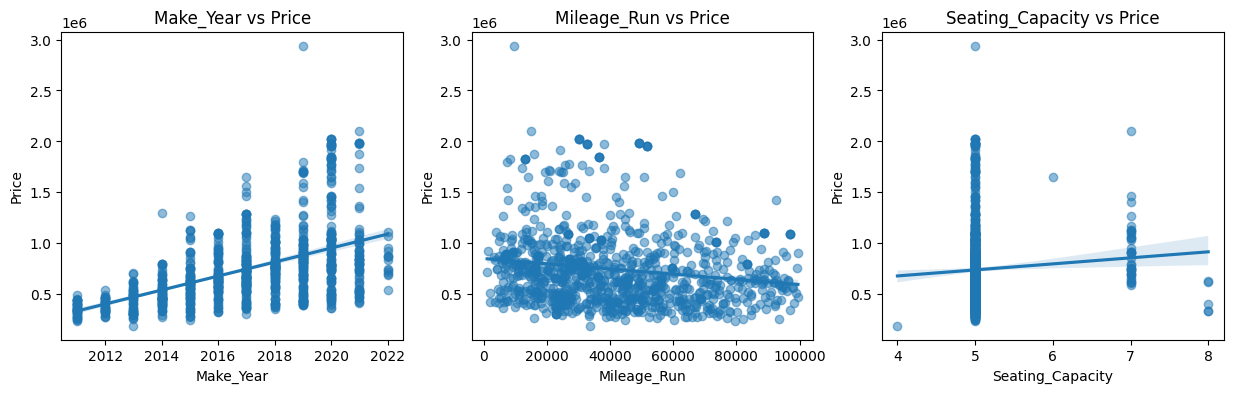

In [63]:
numeric_vars = ['Make_Year', 'Mileage_Run', 'Seating_Capacity']

plt.figure(figsize=(15, 4))

for i, var in enumerate(numeric_cols):
    plt.subplot(1, 3, i + 1)  # i+1 ensures 1-based indexing: subplot(1, 3, 1), (1, 3, 2), ...
    sns.regplot(x=var, y='Price', data=df_encoded, scatter_kws={'alpha': 0.5})
    plt.title(f'{var} vs Price')

plt.tight_layout()
plt.show()

6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [64]:
df_transformed = df_encoded.copy()
df_transformed['Log_Price'] = np.log(df_transformed['Price'])
df_transformed['Log_Mileage'] = np.log(df_transformed['Mileage_Run'] + 1)  # avoid log(0)
df_transformed['Year_x_Seats'] = df_transformed['Make_Year'] * df_transformed['Seating_Capacity']

X_complex = df_transformed.drop(columns=['Price', 'Log_Price', 'Mileage_Run'])  # use Log_Mileage instead
y_complex = df_transformed['Log_Price']

X_train, X_test, y_train, y_test = train_test_split(X_complex, y_complex, test_size=0.2, random_state=42)

model_complex = LinearRegression()
model_complex.fit(X_train, y_train)

train_pred = model_complex.predict(X_train)
test_pred = model_complex.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print("Model D (Transformed + Interactions)")
print(f"Train RMSE: {train_rmse:.3f}, R^2: {train_r2:.3f}")
print(f"Test  RMSE: {test_rmse:.3f}, R^2: {test_r2:.3f}")

Model D (Transformed + Interactions)
Train RMSE: 0.185, R^2: 0.834
Test  RMSE: 0.189, R^2: 0.813


Model D with transformations and interactions does better than 2 of the other models with a slightly lower R^2 than Model C.

7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?

I tested several linear models to predict car prices, starting with simple numeric-only models and building up to a more complex one with log transformations and interaction terms. Model A and Model B underfit the data, while Model D performed better than all except for Model C. Model D which included a log of Price and Mileage_Run plus an interaction between Make_Year and Seating_Capacity ended up reducing the RMSE without overfitting the data. I learned that thoughtful complex models may improve performance but too simple models may miss important patterns.